In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 604ms/step - loss: 0.0969
Average validation loss: 0.614614725112915
4/4 [==============================] - 6s 622ms/step - loss: 0.0969 - val_loss: 0.6146
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 589ms/step - loss: 0.0768 - val_loss: 0.6146
Average validation loss: 0.6422332525253296
4/4 [==============================] - 8s 603ms/step - loss: 0.0768 - val_loss: 0.6284
Epoch 3/10
4/4 [==============================] - 11s 661ms/step - loss: 0.0611 - val_loss: 0.6284
Average validation loss: 0.5859688520431519
4/4 [==============================] - 11s 676ms/step - loss: 0.0611 - val_loss: 0.6143
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_5.pth'.
Epoch 4/10
4/4 [==============================] - 14s 688ms/step

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 784ms/step - loss: 0.0068
Average validation loss: 1.3590123471018956e-09
8/8 [==============================] - 6s 795ms/step - loss: 0.0068 - val_loss: 1.3590e-09
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 852ms/step - loss: 0.0065 - val_loss: 1.3590e-09
Average validation loss: 6.533472287628683e-07
8/8 [==============================] - 13s 865ms/step - loss: 0.0065 - val_loss: 3.2735e-07
Epoch 3/10
8/8 [==============================] - 20s 796ms/step - loss: 0.0064 - val_loss: 3.2735e-07
Average validation loss: 0.0001345762429991737
8/8 [==============================] - 20s 812ms/step - loss: 0.0064 - val_loss: 4.5077e-05
Epoch 4/10
8/8 [==============================] - 26s 774ms/step - loss: 0.0063 - val_loss: 4.5077e-05
Average validation loss: 0.016607534140348434
8/8 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 797ms/step - loss: 0.0096
Average validation loss: 0.13927566099190844
12/12 [==============================] - 10s 809ms/step - loss: 0.0096 - val_loss: 0.1393
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 20s 837ms/step - loss: 0.0093 - val_loss: 0.1393
Average validation loss: 0.16338754679137443
12/12 [==============================] - 20s 850ms/step - loss: 0.0093 - val_loss: 0.1513
Epoch 3/10
12/12 [==============================] - 30s 817ms/step - loss: 0.0090 - val_loss: 0.1513
Average validation loss: 0.03206087934086099
12/12 [==============================] - 30s 830ms/step - loss: 0.0090 - val_loss: 0.1116
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_15.pth'.
Epoch 4/10
12/12 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 13s 800ms/step - loss: 0.0080
Average validation loss: 0.05006040773332643
16/16 [==============================] - 13s 816ms/step - loss: 0.0080 - val_loss: 0.0501
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 26s 801ms/step - loss: 0.0076 - val_loss: 0.0501
Average validation loss: 0.22203430051922624
16/16 [==============================] - 26s 813ms/step - loss: 0.0076 - val_loss: 0.1360
Epoch 3/10
16/16 [==============================] - 39s 795ms/step - loss: 0.0074 - val_loss: 0.1360
Average validation loss: 0.05720859722714522
16/16 [==============================] - 39s 807ms/step - loss: 0.0074 - val_loss: 0.1098
Epoch 4/10
16/16 [==============================] - 52s 801ms/step - loss: 0.0073 - val_loss: 0.1098
Average validation loss: 0.05334466267595417
16/16 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 16s 804ms/step - loss: 0.0043
Average validation loss: 0.02559896850802943
20/20 [==============================] - 16s 817ms/step - loss: 0.0043 - val_loss: 0.0256
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 32s 783ms/step - loss: 0.0041 - val_loss: 0.0256
Average validation loss: 0.17241460411460138
20/20 [==============================] - 32s 799ms/step - loss: 0.0041 - val_loss: 0.0990
Epoch 3/10
20/20 [==============================] - 48s 788ms/step - loss: 0.0040 - val_loss: 0.0990
Average validation loss: 0.03994602112292114
20/20 [==============================] - 48s 803ms/step - loss: 0.0040 - val_loss: 0.0793
Epoch 4/10
20/20 [==============================] - 64s 787ms/step - loss: 0.0039 - val_loss: 0.0793
Average validation loss: 0.04098257269045007
20/20 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 726ms/step - loss: 0.0039
Average validation loss: 0.021461259573698044
24/24 [==============================] - 18s 738ms/step - loss: 0.0039 - val_loss: 0.0215
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 733ms/step - loss: 0.0040 - val_loss: 0.0215
Average validation loss: 0.02830060323079427
24/24 [==============================] - 36s 747ms/step - loss: 0.0040 - val_loss: 0.0249
Epoch 3/10
24/24 [==============================] - 53s 720ms/step - loss: 0.0037 - val_loss: 0.0249
Average validation loss: 0.014315948355942965
24/24 [==============================] - 53s 733ms/step - loss: 0.0037 - val_loss: 0.0214
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_30.pth'.
Epoch 4/10
24/24 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 717ms/step - loss: 0.0053
Average validation loss: 0.18754897266626358
40/40 [==============================] - 29s 728ms/step - loss: 0.0053 - val_loss: 0.1875
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 723ms/step - loss: 0.0050 - val_loss: 0.1875
Average validation loss: 0.026036362629383802
40/40 [==============================] - 58s 733ms/step - loss: 0.0050 - val_loss: 0.1068
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 747ms/step - loss: 0.0048 - val_loss: 0.1068
Average validation loss: 0.3037389233708382
40/40 [==============================] - 89s 760ms/step - loss: 0.0048 - val_loss: 0.1724
Epoch 4/10
40/40 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 733ms/step - loss: 0.0038
Average validation loss: 0.010764240505958847
48/48 [==============================] - 36s 745ms/step - loss: 0.0038 - val_loss: 0.0108
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 719ms/step - loss: 0.0034 - val_loss: 0.0108
Average validation loss: 0.010451041854395085
48/48 [==============================] - 71s 731ms/step - loss: 0.0034 - val_loss: 0.0106
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 726ms/step - loss: 0.0030 - val_loss: 0.0106
Average validation loss: 0.010268442373413103
48/48 [==============================] - 107s 737ms/step - loss: 0.0030 - val_loss: 0.0105
Saved model weights to 'c:\Users\user

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 731ms/step - loss: 0.0041
Average validation loss: 0.01673175361273544
56/56 [==============================] - 42s 743ms/step - loss: 0.0041 - val_loss: 0.0167
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 723ms/step - loss: 0.0034 - val_loss: 0.0167
Average validation loss: 0.013456528773880498
56/56 [==============================] - 83s 735ms/step - loss: 0.0034 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 123s 717ms/step - loss: 0.0030 - val_loss: 0.0151
Average validation loss: 0.016360677645674775
56/56 [==============================] - 124s 729ms/step - loss: 0.0030 - val_loss: 0.0155
Epoch 4/10
56/56 [====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 721ms/step - loss: 0.0030
Average validation loss: 0.011893786839209497
64/64 [==============================] - 47s 733ms/step - loss: 0.0030 - val_loss: 0.0119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 726ms/step - loss: 0.0025 - val_loss: 0.0119
Average validation loss: 0.012789029537524144
64/64 [==============================] - 94s 738ms/step - loss: 0.0025 - val_loss: 0.0123
Epoch 3/10
64/64 [==============================] - 141s 728ms/step - loss: 0.0023 - val_loss: 0.0123
Average validation loss: 0.0111367062768295
64/64 [==============================] - 142s 739ms/step - loss: 0.0023 - val_loss: 0.0119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_80.pth'.
Epoch 4/10
64/64 [=====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 720ms/step - loss: 0.0029
Average validation loss: 0.01021098077762872
72/72 [==============================] - 53s 731ms/step - loss: 0.0029 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 723ms/step - loss: 0.0023 - val_loss: 0.0102
Average validation loss: 0.008680231752805412
72/72 [==============================] - 106s 734ms/step - loss: 0.0023 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 721ms/step - loss: 0.0020 - val_loss: 0.0094
Average validation loss: 0.009152509078073004
72/72 [==============================] - 158s 733ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 4/10
72/72 [==================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 721ms/step - loss: 0.0026
Average validation loss: 0.15072226114571094
80/80 [==============================] - 59s 734ms/step - loss: 0.0026 - val_loss: 0.1507
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 723ms/step - loss: 0.0021 - val_loss: 0.1507
Average validation loss: 0.0067418227205052975
80/80 [==============================] - 117s 734ms/step - loss: 0.0021 - val_loss: 0.0787
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 177s 740ms/step - loss: 0.0018 - val_loss: 0.0787
Average validation loss: 0.00664322052616626
80/80 [==============================] - 178s 751ms/step - loss: 0.0018 - val_loss: 0.0547
Saved model weights to 'c:\Users\u

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 722ms/step - loss: 0.0036
Average validation loss: 0.045175984661113944
96/96 [==============================] - 71s 734ms/step - loss: 0.0036 - val_loss: 0.0452
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 717ms/step - loss: 0.0028 - val_loss: 0.0452
Average validation loss: 0.017619010497583076
96/96 [==============================] - 141s 730ms/step - loss: 0.0028 - val_loss: 0.0314
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 210s 718ms/step - loss: 0.0023 - val_loss: 0.0314
Average validation loss: 0.029842207790352404
96/96 [==============================] - 211s 730ms/step - loss: 0.0023 - val_loss: 0.0309
Epoch 4/10
96/96 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 87s 721ms/step - loss: 0.0025
Average validation loss: 0.009353015820185344
120/120 [==============================] - 88s 733ms/step - loss: 0.0025 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 719ms/step - loss: 0.0021 - val_loss: 0.0094
Average validation loss: 0.0064489334142611675
120/120 [==============================] - 176s 730ms/step - loss: 0.0021 - val_loss: 0.0079
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 720ms/step - loss: 0.0019 - val_loss: 0.0079
Average validation loss: 0.007281049180892296
120/120 [==============================] - 264s 731ms/step - loss: 0.0019 - val_loss: 0.0077
Epoch 4/10
120/120 [

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 114s 789ms/step - loss: 0.0021
Average validation loss: 0.008498504120900129
144/144 [==============================] - 115s 801ms/step - loss: 0.0021 - val_loss: 0.0085
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 228s 785ms/step - loss: 0.0017 - val_loss: 0.0085
Average validation loss: 0.008520023894056471
144/144 [==============================] - 230s 798ms/step - loss: 0.0017 - val_loss: 0.0085
Epoch 3/10
144/144 [==============================] - 344s 790ms/step - loss: 0.0015 - val_loss: 0.0085
Average validation loss: 0.008831109039925246
144/144 [==============================] - 346s 803ms/step - loss: 0.0015 - val_loss: 0.0086
Epoch 4/10
144/144 [==============================] - 459s 785ms/step - loss: 0.0014 - val_loss: 0.0086
Average validation loss: 0.0069421572972916895
144/144 [

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 126s 789ms/step - loss: 0.0015
Average validation loss: 0.005779629147573698
160/160 [==============================] - 128s 802ms/step - loss: 0.0015 - val_loss: 0.0058
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 255s 789ms/step - loss: 0.0013 - val_loss: 0.0058
Average validation loss: 0.005199217360575626
160/160 [==============================] - 257s 801ms/step - loss: 0.0013 - val_loss: 0.0055
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 382s 787ms/step - loss: 0.0011 - val_loss: 0.0055
Average validation loss: 0.005042574226376928
160/160 [==============================] - 384s 799ms/step - loss: 0.0011 - val_loss: 0.0053
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 158s 789ms/step - loss: 0.0028
Average validation loss: 0.008268476723644653
200/200 [==============================] - 160s 802ms/step - loss: 0.0028 - val_loss: 0.0083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 318s 788ms/step - loss: 0.0023 - val_loss: 0.0083
Average validation loss: 0.00916772652646614
200/200 [==============================] - 320s 800ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 3/10
200/200 [==============================] - 477s 784ms/step - loss: 0.0020 - val_loss: 0.0087
Average validation loss: 0.006506027569063235
200/200 [==============================] - 480s 797ms/step - loss: 0.0020 - val_loss: 0.0080
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_250.pth'.
Epoch 4/10
200/200 [

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:05 - loss: 9.6944e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 175s 728ms/step - loss: 0.0019
Average validation loss: 0.009464601775948012
240/240 [==============================] - 178s 740ms/step - loss: 0.0019 - val_loss: 0.0095
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 353s 729ms/step - loss: 0.0016 - val_loss: 0.0095
Average validation loss: 0.011322047292374645
240/240 [==============================] - 355s 741ms/step - loss: 0.0016 - val_loss: 0.0104
Epoch 3/10
240/240 [==============================] - 530s 727ms/step - loss: 0.0014 - val_loss: 0.0104
Average validation loss: 0.008135190614621025
240/240 [==============================] - 533s 738ms/step - loss: 0.0014 - val_loss: 0.0096
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_80\segformer_data_size_300.pth'.
Epoch 4/10
240/240 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09728438577926667, 0.05294354621808202, 0.1262087315384158, 0.09957467943355876, 0.03964626745023879, 0.0206107850985858, 0.029804341002995213, 0.04679411937736864, 0.04048018312486436, 0.02087648479815602, 0.008937846630396078, 0.01092706191825704, 0.011600148970831017, 0.011587612310169866, 0.009135861421701013, 0.004732123491583082, 0.005159898774597716, 0.007213470727384854]
std_val_losses =  [0.16906763334608282, 0.041809959064449904, 0.1344431464734886, 0.0867613681638199, 0.03519658728367329, 0.0176939552217091, 0.04830281318165595, 0.07625962253069776, 0.058026667817123276, 0.05823216588908844, 0.006354502856630158, 0.021182690354111133, 0.012946804607063317, 0.03614521701548273, 0.01822719459124662, 0.0018444574032688134, 0.001999592896810786, 0.005411648880189292]


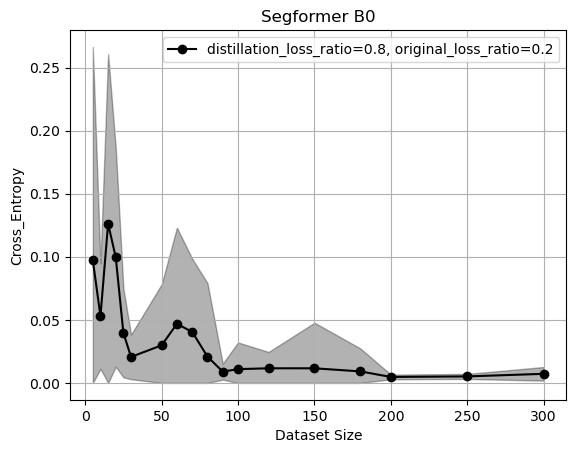

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()